<a href="https://colab.research.google.com/github/sepidehrezvani/10-/blob/main/simulation_of_article_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# نصب کتابخانه‌های لازم (PyTorch برای DRL، اما فعلاً فقط ایمپورتش می‌کنیم)
!pip -q install torch==2.3.1

# ایمپورت‌های عمومی
import numpy as np
import math
import random
import matplotlib.pyplot as plt

# PyTorch برای H-PPO (فعلاً فقط import، بعداً استفاده می‌کنیم)
import torch
import torch.nn as nn
import torch.optim as optim

# برای reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [14]:
# ابعاد شبکه و توپولوژی
M = 2                  # تعداد سلول‌ها (BSها)
C = 1                  # تعداد کاربران مرکزی در هر سلول
E = 1                  # تعداد کاربران لبه در هر سلول
K = 16                 # تعداد عناصر RIS
area_size = 1000       # اندازه مساحت شبیه‌سازی (متر)
HB = 30                # ارتفاع BS (متر)
HRu = 100              # ارتفاع UAV (متر)
H_RG = 50              # ارتفاع RIS زمینی (ساختمان)

# زمان‌بندی پرواز UAV
ts = 50                # تعداد اسلات‌های زمانی
T = list(range(ts))

# توان‌ها و نویز
Pt = 1.0               # توان ارسال BS (نرمال‌شده)
sigma2 = 1e-3          # توان نویز (نرمال‌شده)
kappa = 10             # عامل Rician K-factor

# افت مسیر (PL ~ d^eta)
eta = 3.0

# محدوده‌های قیود
alpha_min, alpha_max = 0.5, 1.0      # محدوده ضریب توان NOMA برای کاربر لبه
phase_min, phase_max = -math.pi, math.pi
gain_min, gain_max = 1.0, 3.0        # حدود تقویت هر عنصر RIS فعال
dmin = 50.0                          # شعاع منطقه ممنوعه اطراف موانع

# مکان BS ها (مرکز سلول‌ها دایره‌ای یا ثابت)
BS_positions = np.array([[250, 500, HB],
                         [750, 500, HB]], dtype=float)

# مکان RIS زمینی (در یک موقعیت میانی)
RG_position = np.array([500, 500, H_RG], dtype=float)

# موانع: چند دایره ممنوعه
obstacles = np.array([
    [400, 400, 60],    # (x, y, height)
    [600, 600, 80],
], dtype=float)

# کاربران مرکزی و لبه (قرارگیری تصادفی ساده)
def random_user_inside(center, radius=200, h=0):
    angle = np.random.uniform(0, 2*np.pi)
    r = np.random.uniform(0, radius)
    return np.array([center[0] + r*np.cos(angle), center[1] + r*np.sin(angle), h], dtype=float)

def random_user_outside(center, radius=300, h=0):
    angle = np.random.uniform(0, 2*np.pi)
    r = np.random.uniform(radius, radius+200)
    return np.array([center[0] + r*np.cos(angle), center[1] + r*np.sin(angle), h], dtype=float)

center_users = []
edge_users = []
for m in range(M):
    center_users.append(random_user_inside(BS_positions[m]))
    edge_users.append(random_user_outside(BS_positions[m]))

center_users = np.array(center_users)
edge_users = np.array(edge_users)

# موقعیت اولیه UAV
Ru_pos = np.array([500.0, 300.0, HRu], dtype=float)

In [15]:
def distance_3d(p1, p2):
    return np.linalg.norm(p1 - p2)

def PL(d, eta=eta):
    return d ** eta

def rayleigh():
    # محو شدگی رایلی با توان واحد
    real = np.random.normal(0, 1/np.sqrt(2))
    imag = np.random.normal(0, 1/np.sqrt(2))
    return complex(real, imag)

def rician(kappa):
    # مولفه LoS و NLoS
    los = complex(1.0, 0.0) # فاز صفر (می‌تونی تصادفی هم بده)
    nlos = rayleigh()
    a = np.sqrt(kappa/(1+kappa))
    b = np.sqrt(1/(1+kappa))
    return a*los + b*nlos

def h_bs_user(BS, U):
    d = distance_3d(BS, U)
    return np.sqrt(PL(d) / 1.0) * rayleigh()

def h_bs_ris(BS, R):
    d = distance_3d(BS, R)
    return np.sqrt(1.0 / PL(d)) * rician(kappa)

def h_ris_user(R, U):
    d = distance_3d(R, U)
    return np.sqrt(1.0 / PL(d)) * rician(kappa)

In [16]:
def ris_phase_matrix(K, phases=None, amplitudes=None):
    if phases is None:
        phases = np.random.uniform(phase_min, phase_max, size=K)
    if amplitudes is None:
        amplitudes = np.ones(K)
    # diag(a_k e^{j θ_k})
    return np.diag(amplitudes * np.exp(1j * phases))

def ris_gain_matrix(K, gains=None):
    if gains is None:
        gains = np.random.uniform(gain_min, gain_max, size=K)
    return np.diag(gains)

# نویز پویا RIS فعال
def ris_noise(K, sigma2=sigma2):
    # نویز مختلط گاوسی با توان sigma2
    real = np.random.normal(0, np.sqrt(sigma2/2), size=K)
    imag = np.random.normal(0, np.sqrt(sigma2/2), size=K)
    return real + 1j*imag

In [17]:
def effective_channel(BS, U, RG, Ru, K=K):
    # کانال‌های پایه
    h_direct = h_bs_user(BS, U)           # مستقیم
    h_bs_RG = h_bs_ris(BS, RG)            # BS->RIS زمینی
    h_RG_U  = h_ris_user(RG, U)           # RIS زمینی -> User
    h_bs_Ru = h_bs_ris(BS, Ru)            # BS->RIS هوایی (UAV)
    h_Ru_U  = h_ris_user(Ru, U)           # RIS هوایی -> User

    # RIS‌ها (در این نسخه: مقداردهی اولیه ساده؛ DRL بعداً تغییرش می‌دهد)
    Theta_RG = ris_phase_matrix(K)
    P_RG     = ris_gain_matrix(K)
    Theta_Ru = ris_phase_matrix(K)
    P_Ru     = ris_gain_matrix(K)

    # نویز RIS
    v_RG = ris_noise(K)
    v_Ru = ris_noise(K)

    # ترکیب سیگنال‌ها: مدل اسکالر ساده‌شده
    # مسیر RIS: h_bs_R * P * Theta * h_R_U
    ris_path_RG = h_bs_RG * np.trace(P_RG @ Theta_RG) * h_RG_U
    ris_path_Ru = h_bs_Ru * np.trace(P_Ru @ Theta_Ru) * h_Ru_U

    # سیگنال مؤثر کل
    h_eff = h_direct + ris_path_RG + ris_path_Ru

    # نویز افزوده از RISها (مقیاس ساده‌شده)
    n_ris = np.trace(P_RG @ Theta_RG) * np.sum(v_RG) + np.trace(P_Ru @ Theta_Ru) * np.sum(v_Ru)

    return h_eff, n_ris

In [18]:
def sinr_noma(h_eff_m, h_eff_j, n_ris_m, n_ris_j, alpha_m, Pt=Pt, sigma2=sigma2):
    """
    h_eff_m: کانال مؤثر BS_m به کاربر هدف
    h_eff_j: کانال مؤثر BS_j (تداخل غیر-CoMP) به همان کاربر
    n_ris_m, n_ris_j: نویز RIS مرتبط با مسیرها
    alpha_m: ضریب توان کاربر لبه در BS_m
    """
    # توان سیگنال برای کاربر مرکزی و لبه
    # کاربر مرکزی: (1 - alpha_m) * Pt
    # کاربر لبه: alpha_m * Pt
    signal_edge = alpha_m * Pt * (abs(h_eff_m)**2)
    signal_center = (1 - alpha_m) * Pt * (abs(h_eff_m)**2)

    # تداخل از BS_j
    interference = Pt * (abs(h_eff_j)**2)

    # نویز کلی (حرارتی + نویز RIS مؤثر)
    noise_total = sigma2 + (abs(n_ris_m) + abs(n_ris_j)) * 1e-2  # مقیاس‌گذاری نرم برای شروع

    # SINR کاربر لبه (ترکیب CoMP-NOMA به‌صورت ساده‌شده)
    sinr_edge = signal_edge / (signal_center + interference + noise_total)

    # SINR کاربر مرکزی پس از SIC
    sinr_center = signal_center / (interference + noise_total)

    return sinr_center, sinr_edge

def rates_noma(sinr_center, sinr_edge):
    # نرخ‌ها با لگاریتم طبیعی (می‌تونی ln یا log2 تنظیم کنی)
    Rc = math.log(1 + sinr_center)
    Re = math.log(1 + sinr_edge)
    return Rc, Re

In [19]:
def evaluate_slot(BS_positions, center_users, edge_users, RG_position, Ru_pos, alpha_list):
    total_rate = 0.0
    per_user_rates = []

    for m in range(M):
        # انتخاب کاربرهای سلول m
        Uc = center_users[m]
        Ue = edge_users[m]

        # BS فعلی و BS تداخل‌گر (غیر-CoMP)
        BS_m = BS_positions[m]
        BS_j = BS_positions[1-m]  # فرض دو سلول؛ تعمیم پذیر

        # کانال مؤثر به کاربر مرکزی
        h_m_c, n_m_c = effective_channel(BS_m, Uc, RG_position, Ru_pos)
        h_j_c, n_j_c = effective_channel(BS_j, Uc, RG_position, Ru_pos)

        # کانال مؤثر به کاربر لبه
        h_m_e, n_m_e = effective_channel(BS_m, Ue, RG_position, Ru_pos)
        h_j_e, n_j_e = effective_channel(BS_j, Ue, RG_position, Ru_pos)

        alpha_m = alpha_list[m]

        # SINR ها
        sinr_c, sinr_e = sinr_noma(h_m_e, h_j_e, n_m_e, n_j_e, alpha_m)  # برای کاربر لبه
        sinr_c_c, sinr_e_c = sinr_noma(h_m_c, h_j_c, n_m_c, n_j_c, alpha_m)  # برای کاربر مرکزی (مدل ساده)

        # نرخ‌ها
        Rc_e, Re_e = rates_noma(sinr_c, sinr_e)
        Rc_c, Re_c = rates_noma(sinr_c_c, sinr_e_c)

        # نرخ مؤثر: جمع نرخ کاربر مرکزی و لبه در سلول m
        cell_rate = Rc_c + Re_e
        total_rate += cell_rate

        per_user_rates.append({
            'cell': m,
            'Rc_center': Rc_c,
            'Re_edge': Re_e,
            'rate_sum_cell': cell_rate
        })

    return total_rate, per_user_rates

In [20]:
def in_no_fly_zone(Ru_pos, obstacles, dmin=dmin):
    for o in obstacles:
        center = np.array([o[0], o[1], o[2]])
        d = distance_3d(Ru_pos, center)
        if d <= dmin:
            return True
    return False

def move_uav(Ru_pos, vx, vy, step=20.0):
    new_pos = Ru_pos.copy()
    new_pos[0] += step * vx
    new_pos[1] += step * vy
    return new_pos

In [21]:
def power_total(Pt=Pt, K=K, gains_scale=1.0):
    # توان BS + توان RIS فعال + توان UAV (بسیار ساده‌شده برای شروع)
    P_BS = M * Pt
    P_RIS = K * gains_scale * 0.1
    P_UAV = 50.0  # ثابت ساده
    return P_BS + P_RIS + P_UAV

def energy_efficiency(rate_sum, P_total):
    return rate_sum / P_total

میانگین نرخ مجموع: 0.47386868810830707
میانگین بهره‌وری انرژی: 0.008840833733363938


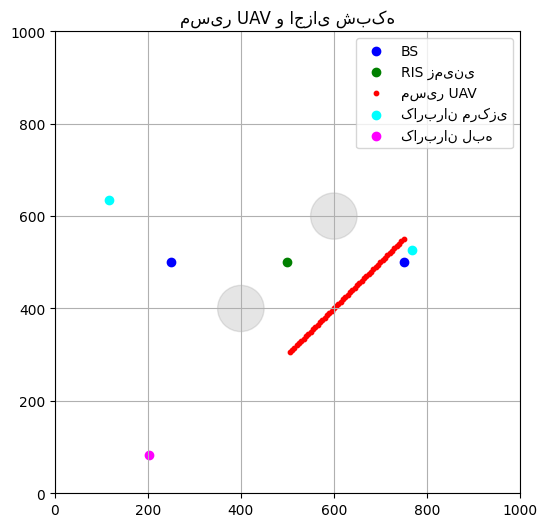

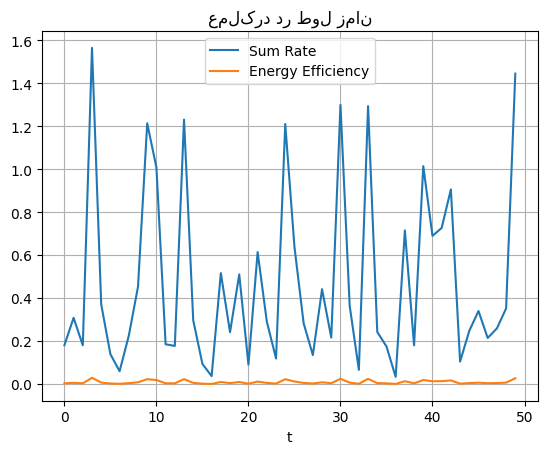

In [22]:
# ضرایب توان NOMA (برای شروع: نزدیک به کاربر لبه)
alpha_list = [0.8 for _ in range(M)]

rate_sums = []
ee_sums = []
Ru_positions_log = []

Ru = Ru_pos.copy()

for t in T:
    # حرکت UAV ساده (سمت مرکز شبکه)
    direction = np.array([0.5, 0.5])
    Ru_candidate = move_uav(Ru, direction[0], direction[1], step=10.0)

    # اگر وارد منطقه ممنوعه شد، حرکت را اصلاح کن
    if in_no_fly_zone(Ru_candidate, obstacles):
        Ru_candidate = move_uav(Ru, -direction[0], -direction[1], step=10.0)

    Ru = Ru_candidate
    Ru_positions_log.append(Ru.copy())

    # ارزیابی نرخ مجموع
    total_rate, per_user_rates = evaluate_slot(BS_positions, center_users, edge_users, RG_position, Ru, alpha_list)
    rate_sums.append(total_rate)

    # بهره‌وری انرژی
    P_tot = power_total()
    ee_sums.append(energy_efficiency(total_rate, P_tot))

print("میانگین نرخ مجموع:", np.mean(rate_sums))
print("میانگین بهره‌وری انرژی:", np.mean(ee_sums))

# رسم مسیر UAV
xs = [p[0] for p in Ru_positions_log]
ys = [p[1] for p in Ru_positions_log]

plt.figure(figsize=(6,6))
plt.scatter(BS_positions[:,0], BS_positions[:,1], c='blue', label='BS')
plt.scatter([RG_position[0]], [RG_position[1]], c='green', label='RIS زمینی')
plt.scatter(xs, ys, s=10, c='red', label='مسیر UAV')
plt.scatter(center_users[:,0], center_users[:,1], c='cyan', label='کاربران مرکزی')
plt.scatter(edge_users[:,0], edge_users[:,1], c='magenta', label='کاربران لبه')
for o in obstacles:
    circle = plt.Circle((o[0], o[1]), dmin, color='gray', alpha=0.2)
    plt.gca().add_patch(circle)
plt.legend()
plt.title("مسیر UAV و اجزای شبکه")
plt.xlim(0, area_size)
plt.ylim(0, area_size)
plt.grid(True)
plt.show()

# رسم نرخ مجموع در طول زمان
plt.figure()
plt.plot(rate_sums, label='Sum Rate')
plt.plot(ee_sums, label='Energy Efficiency')
plt.legend()
plt.title("عملکرد در طول زمان")
plt.xlabel("t")
plt.grid(True)
plt.show()

In [25]:
state_dim = 2 + M + K + K  # [x_uav, y_uav] + alphas + phases(K) + gains(K)
action_dim = 2 + M + K + K # [vx, vy] + delta_alpha(M) + delta_phase(K) + delta_gain(K)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mu = self.net(state)
        std = torch.exp(self.log_std)
        return mu, std

class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 1)
        )
    def forward(self, state):
        return self.net(state)

In [26]:
def clamp_alpha(alpha):
    return float(np.clip(alpha, alpha_min, alpha_max))

def clamp_phase(ph):
    return float(np.clip(ph, phase_min, phase_max))

def clamp_gain(gn):
    return float(np.clip(gn, gain_min, gain_max))

# تبدیل وضعیت به بردار حالت
def build_state(Ru, alpha_list, phases_RG, gains_RG, phases_Ru, gains_Ru):
    state = []
    state += [Ru[0], Ru[1]]
    state += list(alpha_list)
    state += list(phases_RG)
    state += list(gains_RG)
    # برای سادگی، RIS هوایی را همین ابتدا ثابت نگه می‌داریم؛ بعداً اضافه می‌کنیم
    state += list(phases_Ru)
    state += list(gains_Ru)
    return np.array(state, dtype=np.float32)

# نمونه‌گیری کنش از Actor
def select_action(actor, state):
    state_t = torch.tensor(state).unsqueeze(0)
    with torch.no_grad():
        mu, std = actor(state_t)
    dist = torch.distributions.Normal(mu, std)
    action = dist.sample()
    log_prob = dist.log_prob(action).sum(dim=1)
    return action.squeeze(0).numpy(), log_prob.item()

# تابع پاداش ساده: نرخ مجموع - جریمه خروج از محدوده
def reward_function(total_rate, Ru, obstacles):
    penalty = 0.0
    if in_no_fly_zone(Ru, obstacles):
        penalty = 5.0
    # تشویق نزدیکی UAV به مرکز کاربران لبه (ساده)
    target = np.mean(edge_users[:, :2], axis=0)
    dist = np.linalg.norm(Ru[:2] - target)
    reward = total_rate - 0.01*dist - penalty
    return reward

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math

# ---- فرض: این‌ها قبلاً تعریف شده‌اند (از سلول‌های قبلی پروژه) ----
# M, K, phase_min, phase_max, gain_min, gain_max, alpha_min, alpha_max
# BS_positions, center_users, edge_users, RG_position, Ru_pos, obstacles
# h_bs_user, h_bs_ris, h_ris_user, ris_noise, move_uav, in_no_fly_zone
# sinr_noma, rates_noma
# ---------------------------------------------------------------

# ابزارهای محدودسازی
def clamp_alpha(alpha):
    return float(np.clip(alpha, alpha_min, alpha_max))

def clamp_phase(ph):
    return float(np.clip(ph, phase_min, phase_max))

def clamp_gain(gn):
    return float(np.clip(gn, gain_min, gain_max))

# ساخت بردار حالت
def build_state(Ru, alpha_list, phases_RG, gains_RG, phases_Ru, gains_Ru):
    state = []
    state += [Ru[0], Ru[1]]                  # موقعیت UAV (x,y)
    state += list(alpha_list)                # ضرایب توان NOMA (M)
    state += list(phases_RG)                 # فازهای RIS زمینی (K)
    state += list(gains_RG)                  # تقویت RIS زمینی (K)
    state += list(phases_Ru)                 # فازهای RIS هوایی (K)
    state += list(gains_Ru)                  # تقویت RIS هوایی (K)
    return np.array(state, dtype=np.float32)

# Actor-Critic
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mu = self.net(state)
        std = torch.exp(self.log_std)
        return mu, std

class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.Tanh(),
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 1)
        )
    def forward(self, state):
        return self.net(state)

# انتخاب کنش از Actor
def select_action(actor, state):
    state_t = torch.tensor(state).unsqueeze(0)
    with torch.no_grad():
        mu, std = actor(state_t)
    dist = torch.distributions.Normal(mu, std)
    action = dist.sample()
    log_prob = dist.log_prob(action).sum(dim=1)
    return action.squeeze(0).numpy(), log_prob.item()

# تابع پاداش
def reward_function(total_rate, Ru, obstacles):
    penalty = 0.0
    if in_no_fly_zone(Ru, obstacles):
        penalty = 5.0
    target = np.mean(edge_users[:, :2], axis=0)
    dist = np.linalg.norm(Ru[:2] - target)
    reward = total_rate - 0.01*dist - penalty
    return reward

# نسخه‌ی پارامتری از کانال مؤثر که پارامترهای RIS را می‌گیرد
def effective_channel_param(BS, U, RG, Ru, phases_RG, gains_RG, phases_Ru, gains_Ru, K):
    h_direct = h_bs_user(BS, U)
    h_bs_RG = h_bs_ris(BS, RG); h_RG_U = h_ris_user(RG, U)
    h_bs_Ru = h_bs_ris(BS, Ru); h_Ru_U = h_ris_user(Ru, U)

    Theta_RG = np.diag(np.exp(1j*phases_RG))
    P_RG     = np.diag(gains_RG)
    Theta_Ru = np.diag(np.exp(1j*phases_Ru))
    P_Ru     = np.diag(gains_Ru)

    v_RG = ris_noise(K); v_Ru = ris_noise(K)
    ris_path_RG = h_bs_RG * np.trace(P_RG @ Theta_RG) * h_RG_U
    ris_path_Ru = h_bs_Ru * np.trace(P_Ru @ Theta_Ru) * h_Ru_U
    h_eff = h_direct + ris_path_RG + ris_path_Ru
    n_ris = np.trace(P_RG @ Theta_RG) * np.sum(v_RG) + np.trace(P_Ru @ Theta_Ru) * np.sum(v_Ru)
    return h_eff, n_ris

# مقداردهی اولیه
phases_RG = np.random.uniform(phase_min, phase_max, size=K)
gains_RG  = np.random.uniform(gain_min, gain_max, size=K)
phases_Ru = np.random.uniform(phase_min, phase_max, size=K)
gains_Ru  = np.random.uniform(gain_min, gain_max, size=K)
alpha_list = [0.8 for _ in range(M)]
Ru = Ru_pos.copy()

# تعیین دقیق ابعاد حالت و کنش از روی داده‌های اولیه
sample_state = build_state(Ru, alpha_list, phases_RG, gains_RG, phases_Ru, gains_Ru)
state_dim = len(sample_state)                    # باید برابر 2 + M + 4K باشد
action_dim = 2 + M + 4*K                        # [vx, vy] + delta_alpha(M) + delta_phase_RG(K) + delta_gain_RG(K) + delta_phase_Ru(K) + delta_gain_Ru(K)

# ساخت Actor/Critic و بهینه‌سازها
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)
optim_actor = optim.Adam(actor.parameters(), lr=3e-4)
optim_critic = optim.Adam(critic.parameters(), lr=1e-3)

# هایپرپارامترها
gamma = 0.99
eps_clip = 0.2
ts = 50
T = list(range(ts))

# حلقه آموزش
for epoch in range(20):
    log_probs = []
    values = []
    rewards = []
    states = []
    actions = []

    for t in T:
        # ساخت حالت و انتخاب کنش
        state = build_state(Ru, alpha_list, phases_RG, gains_RG, phases_Ru, gains_Ru)
        action, log_p = select_action(actor, state)

        # اندیس‌بندی امن و وابسته به M و K
        idx = 0
        vx, vy = action[idx], action[idx+1]; idx += 2
        dalphas     = action[idx:idx+M]; idx += M
        dphases_RG  = action[idx:idx+K]; idx += K
        dgains_RG   = action[idx:idx+K]; idx += K
        dphases_Ru  = action[idx:idx+K]; idx += K
        dgains_Ru   = action[idx:idx+K]; idx += K

        # به‌روزرسانی با محدودسازی
        Ru = move_uav(Ru, np.tanh(vx), np.tanh(vy), step=10.0)
        for m in range(M):
            alpha_list[m] = clamp_alpha(alpha_list[m] + 0.05*np.tanh(dalphas[m]))
        phases_RG = np.array([clamp_phase(phases_RG[k] + 0.1*np.tanh(dphases_RG[k])) for k in range(K)])
        gains_RG  = np.array([clamp_gain(gains_RG[k]  + 0.1*np.tanh(dgains_RG[k]))  for k in range(K)])
        phases_Ru = np.array([clamp_phase(phases_Ru[k] + 0.1*np.tanh(dphases_Ru[k])) for k in range(K)])
        gains_Ru  = np.array([clamp_gain(gains_Ru[k]  + 0.1*np.tanh(dgains_Ru[k]))  for k in range(K)])

        # محاسبه نرخ مجموع با پارامترهای جاری
        total_rate = 0.0
        for m in range(M):
            Uc = center_users[m]; Ue = edge_users[m]
            BS_m = BS_positions[m]; BS_j = BS_positions[1-m]

            h_m_e, n_m_e = effective_channel_param(BS_m, Ue, RG_position, Ru, phases_RG, gains_RG, phases_Ru, gains_Ru, K)
            h_j_e, n_j_e = effective_channel_param(BS_j, Ue, RG_position, Ru, phases_RG, gains_RG, phases_Ru, gains_Ru, K)
            h_m_c, n_m_c = effective_channel_param(BS_m, Uc, RG_position, Ru, phases_RG, gains_RG, phases_Ru, gains_Ru, K)
            h_j_c, n_j_c = effective_channel_param(BS_j, Uc, RG_position, Ru, phases_RG, gains_RG, phases_Ru, gains_Ru, K)

            sinr_c, sinr_e = sinr_noma(h_m_e, h_j_e, n_m_e, n_j_e, alpha_list[m])
            sinr_c_c, sinr_e_c = sinr_noma(h_m_c, h_j_c, n_m_c, n_j_c, alpha_list[m])
            Rc_c, Re_e = rates_noma(sinr_c_c, sinr_e)

            total_rate += (Rc_c + Re_e)

        r = reward_function(total_rate, Ru, obstacles)

        # ذخیره برای PPO
        states.append(state)
        actions.append(action)
        log_probs.append(log_p)
        rewards.append(r)
        values.append(critic(torch.tensor(state).unsqueeze(0)).item())

    # محاسبه بازگشت و مزیت‌ها
    returns = []
    G = 0.0
    for r in reversed(rewards):
        G = r + gamma*G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32)
    values_t = torch.tensor(values, dtype=torch.float32)
    advantages = returns - values_t

    # بروزرسانی Actor با PPO-Clip
    states_t = torch.tensor(np.array(states), dtype=torch.float32)
    actions_t = torch.tensor(np.array(actions), dtype=torch.float32)

    mu, std = actor(states_t)
    dist = torch.distributions.Normal(mu, std)
    new_log_probs = dist.log_prob(actions_t).sum(dim=1)

    log_probs_t = torch.tensor(log_probs, dtype=torch.float32)
    ratios = torch.exp(new_log_probs - log_probs_t)
    surr1 = ratios * advantages
    surr2 = torch.clamp(ratios, 1 - eps_clip, 1 + eps_clip) * advantages
    actor_loss = -torch.min(surr1, surr2).mean()

    optim_actor.zero_grad()
    actor_loss.backward()
    optim_actor.step()

    # بروزرسانی Critic
    critic_loss = nn.MSELoss()(critic(states_t).squeeze(), returns)
    optim_critic.zero_grad()
    critic_loss.backward()
    optim_critic.step()

    print(f"Epoch {epoch+1:02d} | ActorLoss {actor_loss.item():.3f} | CriticLoss {critic_loss.item():.3f} | AvgReward {np.mean(rewards):.3f}")

Epoch 01 | ActorLoss 55.038 | CriticLoss 3695.645 | AvgReward -2.331
Epoch 02 | ActorLoss 74.328 | CriticLoss 6869.229 | AvgReward -3.384
Epoch 03 | ActorLoss 95.347 | CriticLoss 11562.322 | AvgReward -4.414
Epoch 04 | ActorLoss 104.065 | CriticLoss 13905.262 | AvgReward -4.916
Epoch 05 | ActorLoss 109.225 | CriticLoss 15358.291 | AvgReward -5.180
Epoch 06 | ActorLoss 96.337 | CriticLoss 12373.200 | AvgReward -4.809
Epoch 07 | ActorLoss 78.329 | CriticLoss 8375.731 | AvgReward -4.123
Epoch 08 | ActorLoss 61.782 | CriticLoss 5227.328 | AvgReward -3.240
Epoch 09 | ActorLoss 52.992 | CriticLoss 3791.206 | AvgReward -2.810
Epoch 10 | ActorLoss 54.884 | CriticLoss 4202.210 | AvgReward -2.967
Epoch 11 | ActorLoss 60.596 | CriticLoss 4918.132 | AvgReward -3.096
Epoch 12 | ActorLoss 71.820 | CriticLoss 6880.332 | AvgReward -3.649
Epoch 13 | ActorLoss 101.877 | CriticLoss 13338.454 | AvgReward -4.887
Epoch 14 | ActorLoss 133.775 | CriticLoss 22846.836 | AvgReward -6.348
Epoch 15 | ActorLoss 180

In [30]:
# اینجا می‌تونی پارامترهای بهینه را ذخیره کنی
torch.save(actor.state_dict(), "actor.pth")
torch.save(critic.state_dict(), "critic.pth")

print("مدل‌ها ذخیره شدند.")

مدل‌ها ذخیره شدند.


میانگین نرخ مجموع در تست: 0.4810366203489634


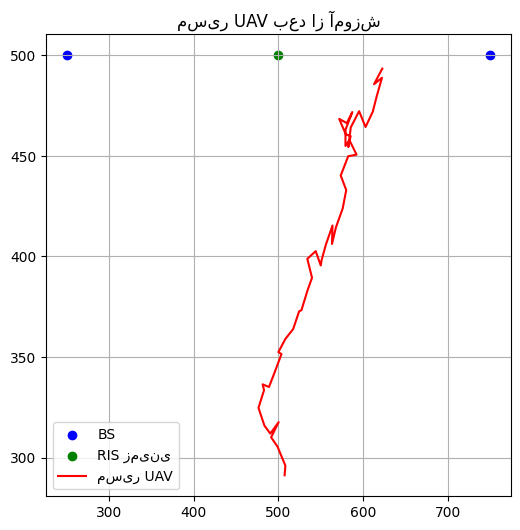

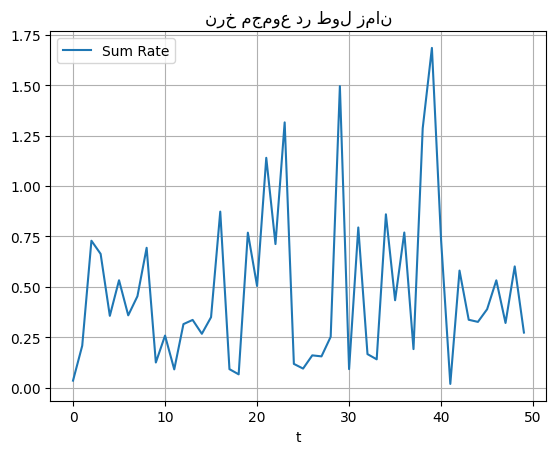

In [31]:
# بارگذاری مدل آموزش‌دیده
actor.load_state_dict(torch.load("actor.pth"))

Ru = Ru_pos.copy()
alpha_list = [0.8 for _ in range(M)]
phases_RG = np.random.uniform(phase_min, phase_max, size=K)
gains_RG  = np.random.uniform(gain_min, gain_max, size=K)
phases_Ru = np.random.uniform(phase_min, phase_max, size=K)
gains_Ru  = np.random.uniform(gain_min, gain_max, size=K)

rate_sums = []
Ru_positions_log = []

for t in T:
    state = build_state(Ru, alpha_list, phases_RG, gains_RG, phases_Ru, gains_Ru)
    action, _ = select_action(actor, state)

    # حرکت UAV بر اساس کنش Actor
    vx, vy = action[0], action[1]
    Ru = move_uav(Ru, np.tanh(vx), np.tanh(vy), step=10.0)
    Ru_positions_log.append(Ru.copy())

    # محاسبه نرخ مجموع
    total_rate, _ = evaluate_slot(BS_positions, center_users, edge_users, RG_position, Ru, alpha_list)
    rate_sums.append(total_rate)

print("میانگین نرخ مجموع در تست:", np.mean(rate_sums))

# رسم مسیر UAV
xs = [p[0] for p in Ru_positions_log]
ys = [p[1] for p in Ru_positions_log]

plt.figure(figsize=(6,6))
plt.scatter(BS_positions[:,0], BS_positions[:,1], c='blue', label='BS')
plt.scatter([RG_position[0]], [RG_position[1]], c='green', label='RIS زمینی')
plt.plot(xs, ys, c='red', label='مسیر UAV')
plt.legend()
plt.title("مسیر UAV بعد از آموزش")
plt.grid(True)
plt.show()

# رسم نرخ مجموع در طول زمان
plt.figure()
plt.plot(rate_sums, label='Sum Rate')
plt.legend()
plt.title("نرخ مجموع در طول زمان")
plt.xlabel("t")
plt.grid(True)
plt.show()